## Results of Host Prediction
### Dataset: Coronaviridae S prot UniRef90, EMBL mapping, Vertebrates

**Models**: TF - Pretrain  + finetune

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1336

**Alignment**: Yes, No

**Classification**: Multi-class

**\# classes**: 8, 2

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 


In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
! pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 285 kB 2.7 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statannotations 0.6.0 requires seaborn<0.12,>=0.9.0, but you have seaborn 0.12.0 which is incompatible.


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean

In [4]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"

def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath=None):
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 8),
        "xtick.labelsize": 14,
        "ytick.labelsize": 14    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", order=metadata_sorted)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=18)
    ax.set_xlabel("Classes", size=18, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_ticklabels(ax, axis="x")
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df

### UniProt

In [5]:
file_paths = {
    "ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_224530.csv"),
    "ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_132840.csv"),
    "VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240326/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniprot_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    "Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
}

classes = ["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

Read output ProteinBERT = (1785, 11)
Read output ProteinBERT-2048 = (1785, 11)
Read output VirProBERT-1366 = (1785, 10)


/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/pytho

Read output Hybrid-sl256st64 = (1785, 10)
Read output Hybrid-sl256st64-CLS = (1785, 10)


<Figure size 432x288 with 0 Axes>

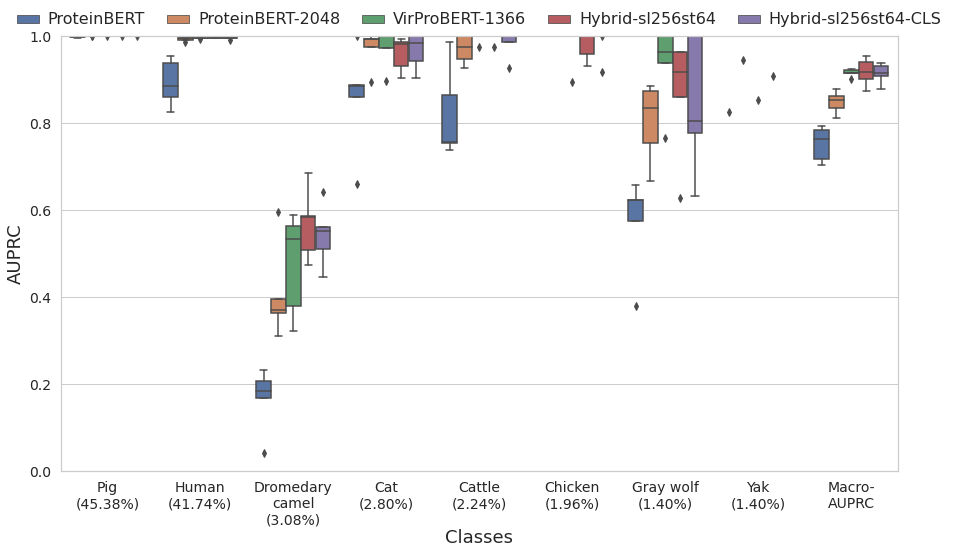

,class,auprc,model,itr
0,model_seq_len,0.500000,ProteinBERT,0
1,Pig (45.38%),0.998056,ProteinBERT,0
2,Cattle (2.24%),0.985243,ProteinBERT,0
3,Yak (1.40%),1.000000,ProteinBERT,0
4,Chicken (1.96%),1.000000,ProteinBERT,0
...,...,...,...,...
230,Gray wolf (1.40%),0.776667,Hybrid-sl256st64-CLS,4
231,Dromedary camel (3.08%),0.642265,Hybrid-sl256st64-CLS,4
232,Cat (2.80%),0.902710,Hybrid-sl256st64-CLS,4
233,Human (41.74%),0.997157,Hybrid-sl256st64-CLS,4


In [6]:
class_wise_auprc_analysis(file_paths, classes)

### UniRef90

In [7]:

file_paths = {
    "ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_222843.csv"),
    "ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_140312.csv"),
    "VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240320/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniref90_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    "Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv")
}

classes = ["Chicken", "Human", "Cat", "Pig", "Gray wolf", "Horshoe bat", "Ferret", "Chinese rufous horseshoe bat"]

Read output ProteinBERT = (345, 11)
Read output ProteinBERT-2048 = (345, 11)
Read output VirProBERT-1366 = (345, 10)
Read output Hybrid-sl256st64 = (345, 10)
Read output Hybrid-sl256st64-CLS = (345, 10)


/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/pytho

<Figure size 432x288 with 0 Axes>

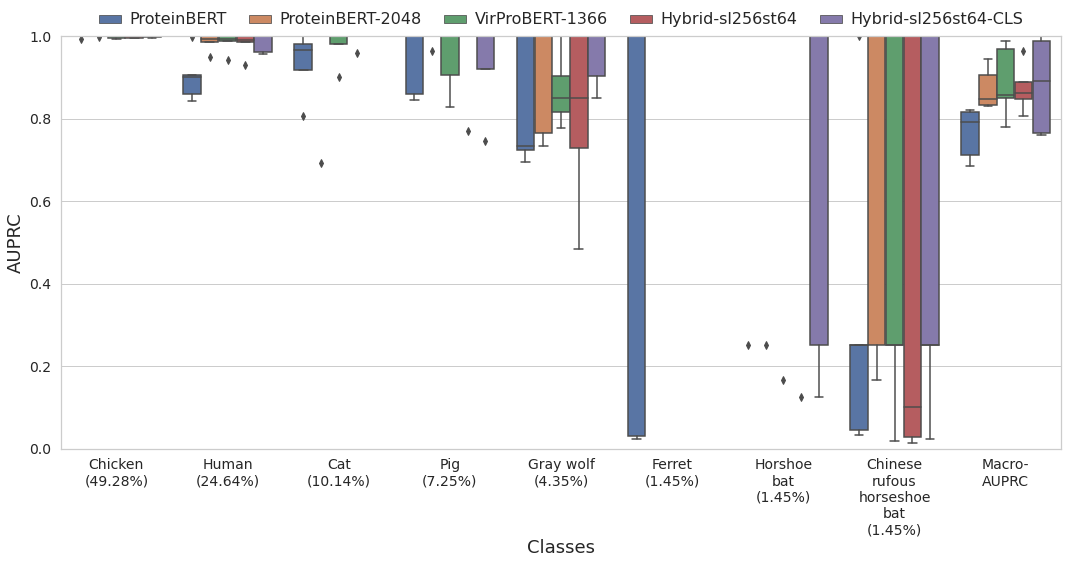

,class,auprc,model,itr
0,Chinese rufous horseshoe bat (1.45%),0.045455,ProteinBERT,0
1,Horshoe bat (1.45%),1.000000,ProteinBERT,0
2,Ferret (1.45%),0.029412,ProteinBERT,0
3,model_seq_len,0.500000,ProteinBERT,0
4,Pig (7.25%),1.000000,ProteinBERT,0
...,...,...,...,...
230,Chicken (49.28%),1.000000,Hybrid-sl256st64-CLS,4
231,Gray wolf (4.35%),1.000000,Hybrid-sl256st64-CLS,4
232,Cat (10.14%),1.000000,Hybrid-sl256st64-CLS,4
233,Human (24.64%),1.000000,Hybrid-sl256st64-CLS,4


In [8]:
class_wise_auprc_analysis(file_paths, classes)